In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from Levenshtein import distance as levenshtein_distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import ttest_ind
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import molecular_weight

# Load datasets
df1 = pd.read_excel('./Final_non_redundant_sequences.xlsx',na_filter = False, index_col=False) # take care the NA sequence 
df2 = pd.read_excel('./kelm.xlsx',na_filter = False, index_col=False) # take care the NA sequence 

# Ensure columns are named 'sequence'
df1['sequence'] = df1['sequence'].astype(str)
df2['sequence'] = df2['sequence'].astype(str)

Plot saved to ./dataset_exploration/plot_length_distribution


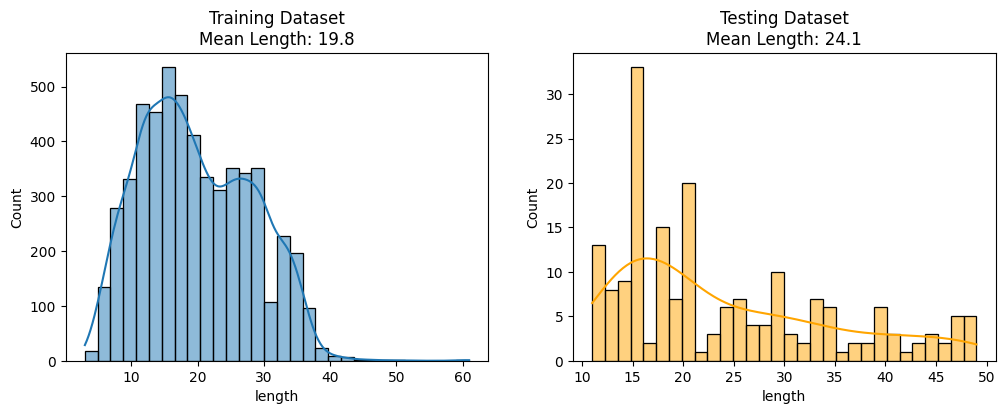

In [40]:
def plot_length_distribution(df1, df2, title1="Training Dataset", title2="Testing Dataset", save_path="./dataset_exploration/plot_length_distribution"):
    df1['length'] = df1['sequence'].apply(len)
    df2['length'] = df2['sequence'].apply(len)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df1['length'], bins=30, kde=True)
    plt.title(f"{title1}\nMean Length: {df1['length'].mean():.1f}")
    
    plt.subplot(1, 2, 2)
    sns.histplot(df2['length'], bins=30, kde=True, color='orange')
    plt.title(f"{title2}\nMean Length: {df2['length'].mean():.1f}")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {save_path}")
    
    plt.show()

plot_length_distribution(df1, df2)

Plot saved to ./dataset_exploration/plot_aa_composition


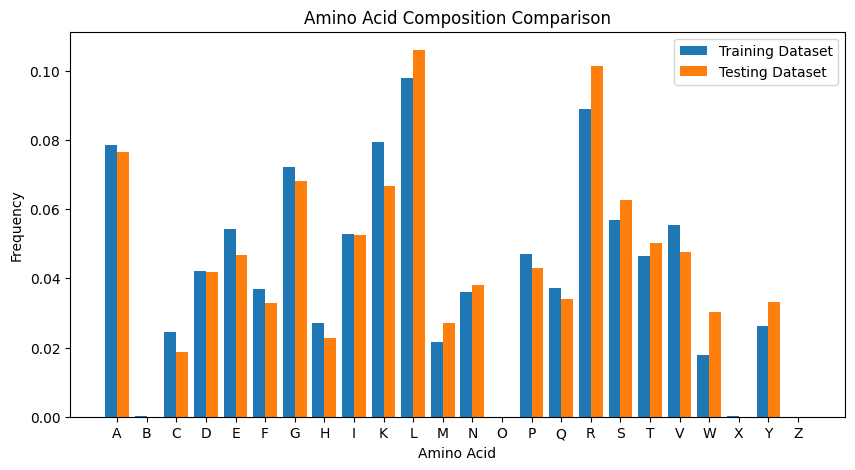

In [42]:
def plot_aa_composition(df1, df2, save_path="./dataset_exploration/plot_aa_composition"):
    def get_aa_freq(sequences):
        aa_counts = Counter("".join(sequences))
        total = sum(aa_counts.values())
        return {aa: count/total for aa, count in aa_counts.items()}
    
    freq1 = get_aa_freq(df1['sequence'])
    freq2 = get_aa_freq(df2['sequence'])
    aas = sorted(set(freq1.keys()).union(set(freq2.keys())))
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(aas)) - 0.2, [freq1.get(aa, 0) for aa in aas], width=0.4, label='Training Dataset')
    plt.bar(np.arange(len(aas)) + 0.2, [freq2.get(aa, 0) for aa in aas], width=0.4, label='Testing Dataset')
    plt.xticks(np.arange(len(aas)), aas)
    plt.xlabel("Amino Acid")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Amino Acid Composition Comparison")
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {save_path}")
        
    plt.show()

plot_aa_composition(df1, df2)

Plot saved to ./dataset_exploration/hydrophobicity


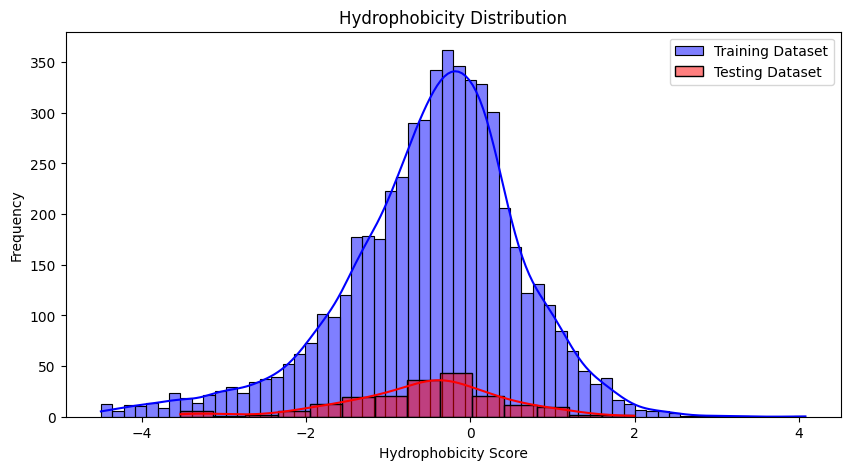

Hydrophobicity Comparison: p-value = 0.255 (significant if < 0.05)


In [43]:
# ======================
# 4. Physicochemical Properties
# ======================
def calculate_hydrophobicity(sequence):
    """Kyte-Doolittle hydrophobicity scale (example property)."""
    hydrophobicity = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    return sum(hydrophobicity.get(aa, 0) for aa in sequence) / len(sequence)

def plot_physicochemical_properties(df1, df2, save_path="./dataset_exploration/hydrophobicity"):
    """Compare hydrophobicity distributions."""
    df1['hydrophobicity'] = df1['sequence'].apply(calculate_hydrophobicity)
    df2['hydrophobicity'] = df2['sequence'].apply(calculate_hydrophobicity)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(df1['hydrophobicity'], color='blue', label='Training Dataset', kde=True, alpha=0.5)
    sns.histplot(df2['hydrophobicity'], color='red', label='Testing Dataset', kde=True, alpha=0.5)
    plt.title("Hydrophobicity Distribution")
    plt.xlabel("Hydrophobicity Score")
    plt.ylabel("Frequency")
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {save_path}")
        
    plt.show()

    # Statistical test
    t_stat, p_value = ttest_ind(df1['hydrophobicity'], df2['hydrophobicity'])
    print(f"Hydrophobicity Comparison: p-value = {p_value:.3f} (significant if < 0.05)")

plot_physicochemical_properties(df1, df2)

In [45]:
def custom_molecular_weight(sequence):
    """Calculate MW including non-standard AAs."""
    aa_weights = {
        'A': 89.09, 'R': 174.20, 'N': 132.12, 'D': 133.10, 'C': 121.16,
        'E': 147.13, 'Q': 146.15, 'G': 75.07, 'H': 155.16, 'I': 131.18,
        'L': 131.18, 'K': 146.19, 'M': 149.21, 'F': 165.19, 'P': 115.13,
        'S': 105.09, 'T': 119.12, 'W': 204.23, 'Y': 181.19, 'V': 117.15,
        'Z': 128.13,  # Example: Glx (Z = Glutamine/Glutamic acid average)
        'X': 110.00,  # Unknown AA (placeholder)
    }
    return sum(aa_weights.get(aa, 0) for aa in sequence)
    
def calculate_physicochemical_properties(sequence):
    """
    Calculate key physicochemical properties for a peptide sequence.
    
    Args:
        sequence (str): Amino acid sequence (e.g., "ACDEFGHIKLMNPQRSTVWY").
    
    Returns:
        dict: Properties including hydrophobicity, charge, molecular weight, etc.
    """
    # Initialize ProteinAnalysis object (BioPython)
    try:
        prot = ProteinAnalysis(sequence)
    except:
        return None  # Skip invalid sequences
    
    # --- Hydrophobicity (Kyte-Doolittle scale) ---
    hydrophobicity_scale = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    hydrophobicity = np.mean([hydrophobicity_scale.get(aa, 0) for aa in sequence])
    
    # --- Net Charge (at pH 7) ---
    #charge_scale = {
    #    'R': +1, 'K': +1, 'H': +1,  # Positive
    #    'D': -1, 'E': -1,  # Negative
    #}
    #net_charge = sum(charge_scale.get(aa, 0) for aa in sequence)
    # --- Net Charge (at pH 7.4) ---
    net_charge = prot.charge_at_pH(7.4)
    
    # --- Molecular Weight (monoisotopic, Da) ---
    #mw = molecular_weight(sequence, seq_type='protein')
    mw = custom_molecular_weight(sequence)
    
    # --- Isoelectric Point (pI, approximation) ---
    # Requires Bio.SeqUtils.ProtParam (may not handle modified residues)
    try:
        prot_analysis = ProteinAnalysis(sequence)
        pI = prot_analysis.isoelectric_point()
    except:
        pI = np.nan  # Fallback if sequence has non-standard AAs
        
    # --- Instability Index (predicts stability) ---
    #instability = prot.instability_index()
    
    # --- Aliphatic Index (thermostability) ---
    aliphatic_aas = {'A': 1.0, 'V': 1.0, 'I': 1.0, 'L': 1.0}
    aliphatic_index = sum(aliphatic_aas.get(aa, 0) for aa in sequence) / len(sequence) * 100
    
    # --- Aromaticity ---
    aromaticity = prot.aromaticity()
    
    # --- Boman Index (protein-protein interaction potential) ---
    boman_scale = {
        'A': 0.0, 'R': -2.5, 'N': -0.5, 'D': -0.5, 'C': -1.0,
        'Q': -0.5, 'E': -0.5, 'G': 0.0, 'H': -0.5, 'I': 0.5,
        'L': 0.5, 'K': -1.5, 'M': 0.0, 'F': 0.5, 'P': 0.0,
        'S': 0.0, 'T': 0.0, 'W': 0.0, 'Y': 0.0, 'V': 0.0
    }
    boman = sum(boman_scale.get(aa, 0) for aa in sequence) / len(sequence)
    
    gravy = sum(hydrophobicity_scale.get(aa, 0) for aa in sequence) / len(sequence)
    
    return {
        'hydrophobicity': hydrophobicity,
        'charge': net_charge,
        'molecular_weight': mw,
        'isoelectric_point': pI,
        'aliphatic_index': aliphatic_index,
        #'instability_index': instability,
        'aromaticity': aromaticity,
        'boman_index': boman,
        'gravy': gravy
    }

def map_nonstandard_aas(sequence):
    """Replace non-standard AAs with their closest equivalents."""
    aa_map = {"Z": "E", "B": "D", "X": "A"}  # Customize as needed
    return "".join(aa_map.get(aa, aa) for aa in sequence)

df1["sequence"] = df1["sequence"].apply(map_nonstandard_aas)
df2["sequence"] = df2["sequence"].apply(map_nonstandard_aas)

properties1 = df1['sequence'].apply(calculate_physicochemical_properties).apply(pd.Series)
df1 = pd.concat([df1, properties1], axis=1)
print(df1.head())

properties2 = df2['sequence'].apply(calculate_physicochemical_properties).apply(pd.Series)
df2 = pd.concat([df2, properties2], axis=1)
print(df2.head())


                       sequence  label  length  hydrophobicity  \
0  MAMPGEPRRANVMAHKLEPASLQLRSCA      1      28       -0.307143   
1      LNSAGYLLGKINLKALAALAKKIL      1      24        0.795833   
2     GWTLNSAGYLLGKLKALAALAKKIL      1      25        0.644000   
3              KLALKLALKALKAALK      1      16        0.768750   
4            KLALKLALKAWKAALKLA      1      18        0.733333   

   hydrophobicity    charge  molecular_weight  isoelectric_point  \
0       -0.307143  1.296672           3552.05           9.493115   
1        0.795833  3.544925           2911.49          10.176866   
2        0.644000  3.544925           3046.61          10.176866   
3        0.768750  4.544925           1963.48          10.602487   
4        0.733333  4.544925           2256.80          10.602487   

   aliphatic_index  aromaticity  boman_index     gravy  
0        32.142857     0.000000    -0.392857 -0.307143  
1        58.333333     0.041667    -0.104167  0.795833  
2        52.000000     

Plot saved to ./dataset_exploration/hydrophobicityComp


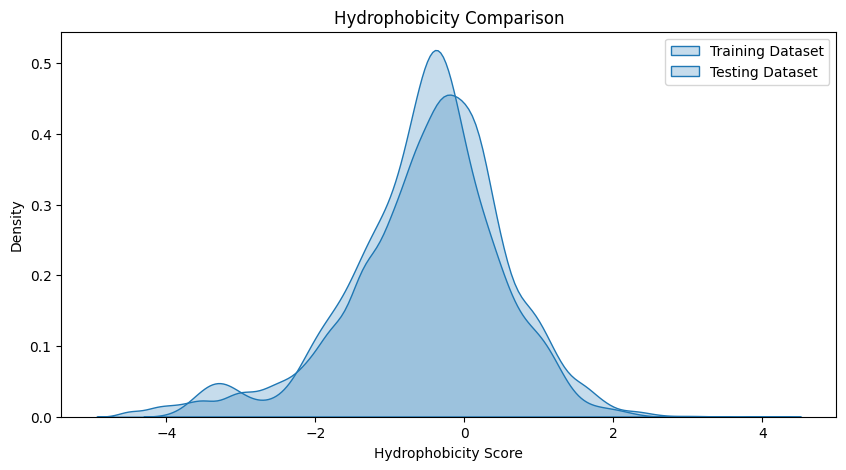

Plot saved to ./dataset_exploration/NetCharge


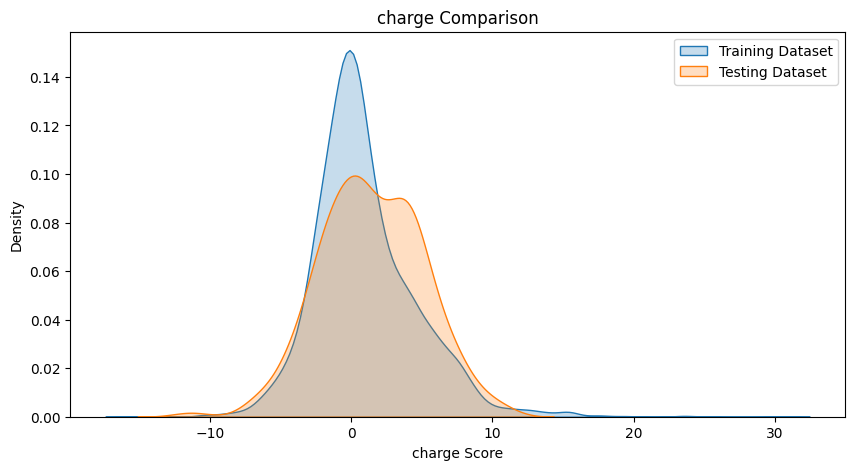

Plot saved to ./dataset_exploration/molecular_weight


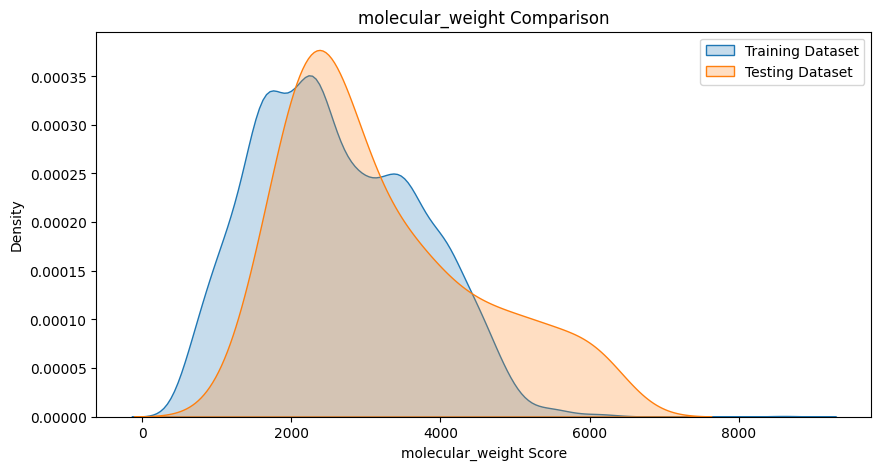

Plot saved to ./dataset_exploration/aliphatic_index


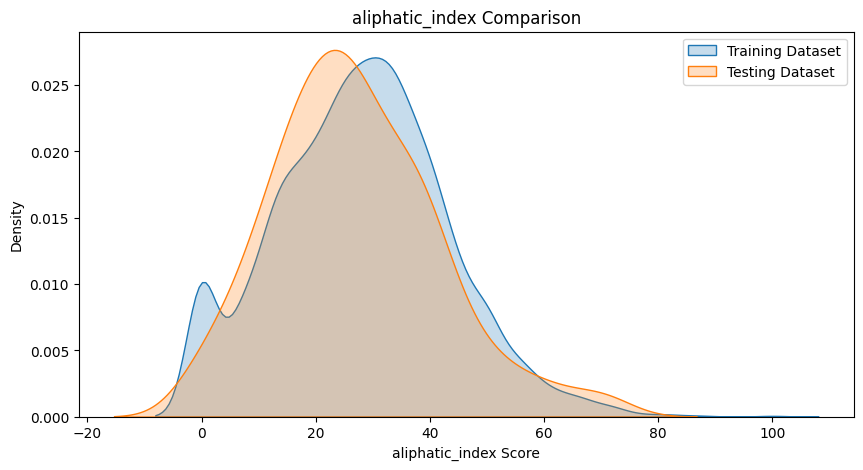

Plot saved to ./dataset_exploration/aromaticity


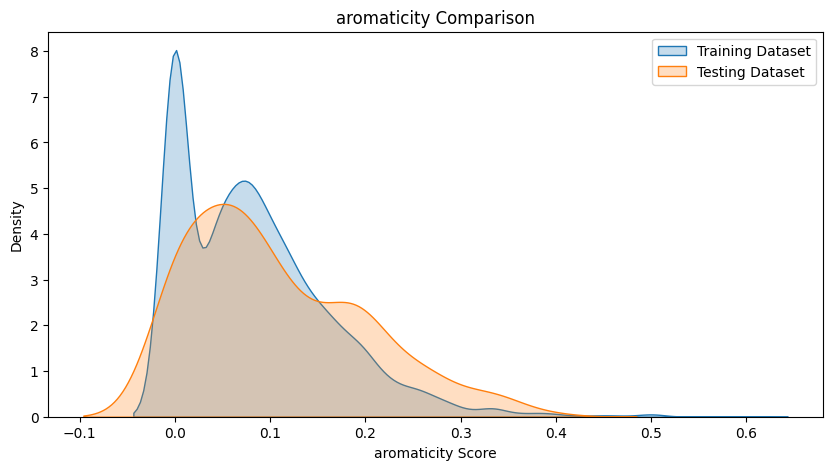

Plot saved to ./dataset_exploration/boman_index


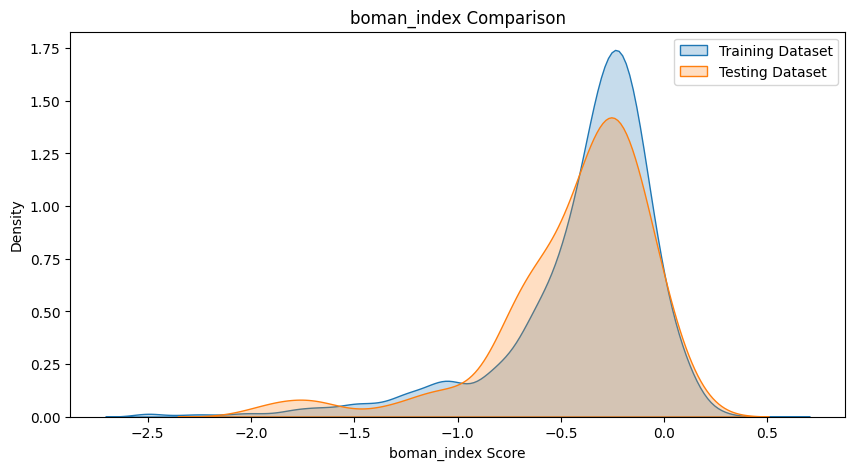

Plot saved to ./dataset_exploration/gravy


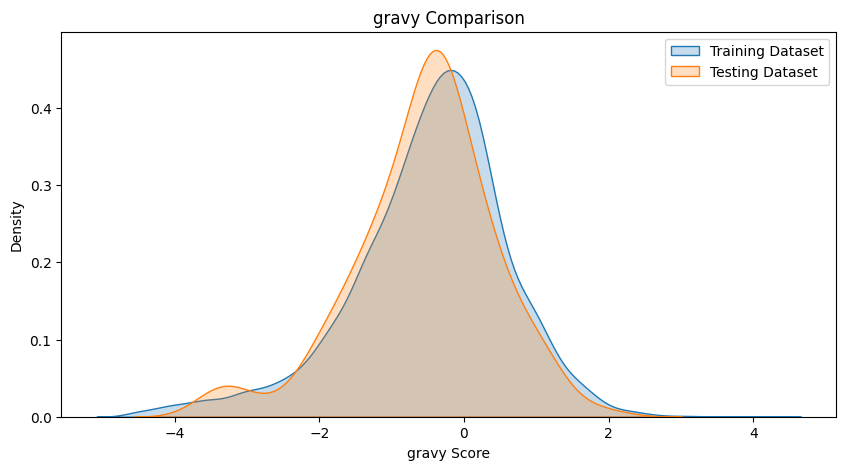

In [46]:
# Compare hydrophobicity between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['hydrophobicity'], label="Training Dataset", fill=True)
sns.kdeplot(df2['hydrophobicity'], label="Testing Dataset", fill=True)
plt.title("Hydrophobicity Comparison")
plt.xlabel("Hydrophobicity Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/hydrophobicityComp"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare charge between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['charge'], label="Training Dataset", fill=True)
sns.kdeplot(df2['charge'], label="Testing Dataset", fill=True)
plt.title("charge Comparison")
plt.xlabel("charge Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/NetCharge"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare molecular_weight between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['molecular_weight'], label="Training Dataset", fill=True)
sns.kdeplot(df2['molecular_weight'], label="Testing Dataset", fill=True)
plt.title("molecular_weight Comparison")
plt.xlabel("molecular_weight Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/molecular_weight"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare aliphatic_index between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['aliphatic_index'], label="Training Dataset", fill=True)
sns.kdeplot(df2['aliphatic_index'], label="Testing Dataset", fill=True)
plt.title("aliphatic_index Comparison")
plt.xlabel("aliphatic_index Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/aliphatic_index"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare aromaticity between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['aromaticity'], label="Training Dataset", fill=True)
sns.kdeplot(df2['aromaticity'], label="Testing Dataset", fill=True)
plt.title("aromaticity Comparison")
plt.xlabel("aromaticity Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/aromaticity"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare boman_index between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['boman_index'], label="Training Dataset", fill=True)
sns.kdeplot(df2['boman_index'], label="Testing Dataset", fill=True)
plt.title("boman_index Comparison")
plt.xlabel("boman_index Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/boman_index"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()
# Compare gravy between two datasets
plt.figure(figsize=(10, 5))
sns.kdeplot(df1['gravy'], label="Training Dataset", fill=True)
sns.kdeplot(df2['gravy'], label="Testing Dataset", fill=True)
plt.title("gravy Comparison")
plt.xlabel("gravy Score")
plt.ylabel("Density")
plt.legend()
save_path="./dataset_exploration/gravy"
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
print(f"Plot saved to {save_path}")
plt.show()

Intra-dataset similarity (Training Dataset): 22.26
Intra-dataset similarity (Testing Dataset): 24.50
Inter-dataset similarity: 23.93


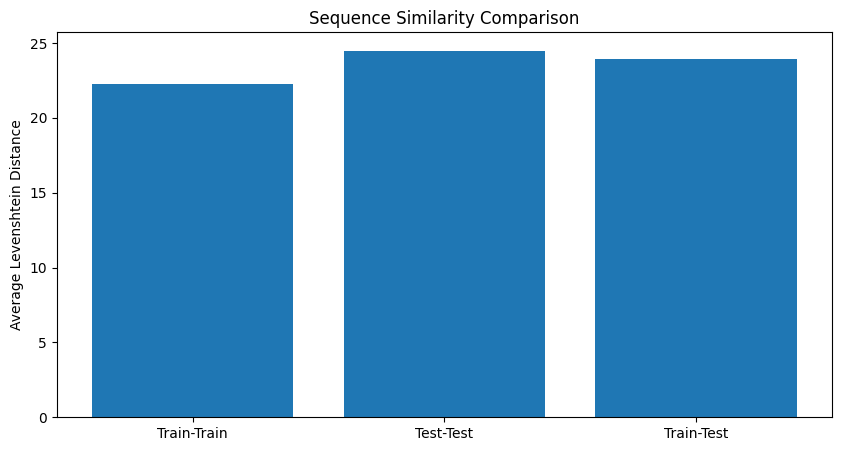

In [35]:
# ======================
# 6. Sequence Similarity (Levenshtein Distance)
# ======================
def calculate_pairwise_similarity(sequences1, sequences2, sample_size=50):
    """Calculate average Levenshtein distance between datasets."""
    np.random.seed(42)
    sample1 = np.random.choice(sequences1, min(sample_size, len(sequences1)), replace=False)
    sample2 = np.random.choice(sequences2, min(sample_size, len(sequences2)), replace=False)
    
    distances = []
    for seq1 in sample1:
        for seq2 in sample2:
            distances.append(levenshtein_distance(seq1, seq2))
    
    return np.mean(distances)

def compare_sequence_similarity(df1, df2):
    """Compare intra- and inter-dataset sequence similarity."""
    intra_dist1 = calculate_pairwise_similarity(df1['sequence'], df1['sequence'])
    intra_dist2 = calculate_pairwise_similarity(df2['sequence'], df2['sequence'])
    inter_dist = calculate_pairwise_similarity(df1['sequence'], df2['sequence'])
    
    print(f"Intra-dataset similarity (Training Dataset): {intra_dist1:.2f}")
    print(f"Intra-dataset similarity (Testing Dataset): {intra_dist2:.2f}")
    print(f"Inter-dataset similarity: {inter_dist:.2f}")
    
    # Plot distance distributions
    plt.figure(figsize=(10,5))
    plt.bar(['Train-Train', 'Test-Test', 'Train-Test'], 
            [intra_dist1, intra_dist2, inter_dist])
    plt.ylabel('Average Levenshtein Distance')
    plt.title('Sequence Similarity Comparison')
    plt.show()

compare_sequence_similarity(df1, df2)

/home/castilmg/miniconda3/envs/esm-axp-gdl-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/castilmg/miniconda3/envs/esm-axp-gdl-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Plot saved to ./dataset_exploration/tsne


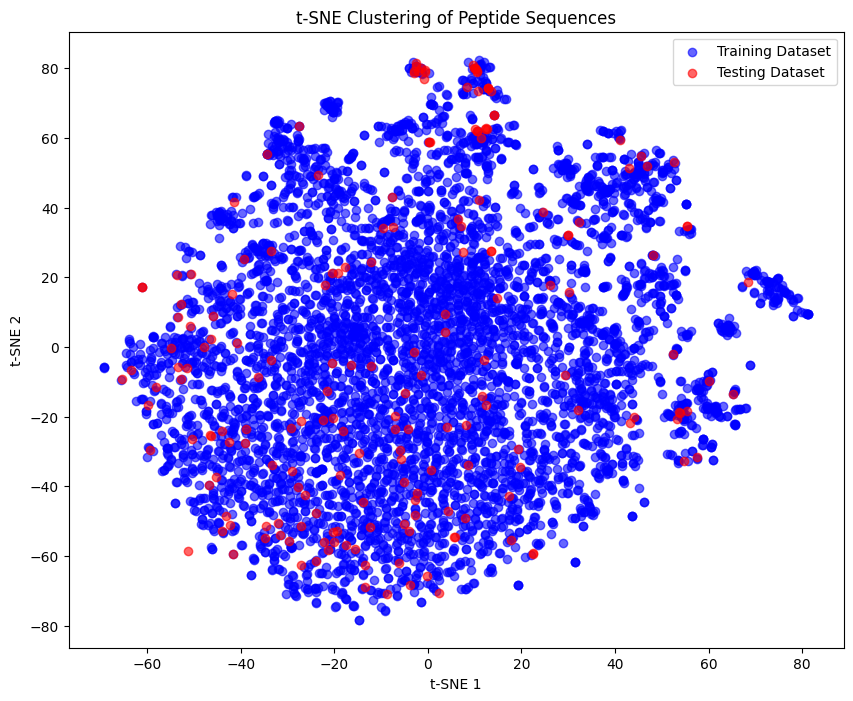

In [47]:
# ======================
# 7. Clustering (t-SNE/PCA)
# ======================
def plot_clustering(df1, df2, save_path="./dataset_exploration/tsne"):
    """Visualize peptide clusters using t-SNE."""
    from sklearn.feature_extraction.text import CountVectorizer
    
    # One-hot encoding of sequences
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(1, 1))
    X1 = vectorizer.fit_transform(df1['sequence'])
    X2 = vectorizer.transform(df2['sequence'])
    X = np.vstack([X1.toarray(), X2.toarray()])
    
    # Standardize and reduce dimensionality
    X_scaled = StandardScaler().fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[:len(df1), 0], X_tsne[:len(df1), 1], c='blue', label='Training Dataset', alpha=0.6)
    plt.scatter(X_tsne[len(df1):, 0], X_tsne[len(df1):, 1], c='red', label='Testing Dataset', alpha=0.6)
    plt.title("t-SNE Clustering of Peptide Sequences")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.legend()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {save_path}")
        
    plt.show()

plot_clustering(df1, df2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from collections import defaultdict
import warnings

# Suppress some warnings for cleaner output
warnings.filterwarnings('ignore')

In [43]:


class SequenceAnalyzer:
    def __init__(self, dataset_path, label_col='label', sequence_col='sequence'):
        """
        Initialize the analyzer with dataset path and column names
        """
        self.dataset_path = dataset_path
        self.label_col = label_col
        self.sequence_col = sequence_col
        self.data = None
        self.class_stats = {}
        
        # Define additional physicochemical scales
        self.hydrophobicity_scale = {
            'A': 0.62, 'R': -2.53, 'N': -0.78, 'D': -0.90, 'C': 0.29,
            'Q': -0.85, 'E': -0.74, 'G': 0.48, 'H': -0.40, 'I': 1.38,
            'L': 1.06, 'K': -1.50, 'M': 0.64, 'F': 1.19, 'P': 0.12,
            'S': -0.18, 'T': -0.05, 'W': 0.81, 'Y': 0.26, 'V': 1.08
        }
        
        self.charge_scale = {
            'A': 0, 'R': 1, 'N': 0, 'D': -1, 'C': 0,
            'Q': 0, 'E': -1, 'G': 0, 'H': 0.5, 'I': 0,
            'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0,
            'S': 0, 'T': 0, 'W': 0, 'Y': 0, 'V': 0
        }
        
    def load_data(self):
        """Load the dataset from file"""
        if self.dataset_path.endswith('.csv'):
            self.data = pd.read_csv(self.dataset_path)
        elif self.dataset_path.endswith('.tsv'):
            self.data = pd.read_csv(self.dataset_path, sep='\t')
        elif self.dataset_path.endswith('.xlsx'):
            self.data = pd.read_excel(self.dataset_path)
        else:
            raise ValueError("Unsupported file format. Please use CSV, TSV, or Excel.")
        
        print(f"Dataset loaded with {len(self.data)} entries and {self.data[self.label_col].nunique()} classes.")
        
    def analyze_classes(self):
        """Run all analyses for each class"""
        if self.data is None:
            self.load_data()
            
        classes = self.data[self.label_col].unique()
        
        for class_name in classes:
            class_data = self.data[self.data[self.label_col] == class_name]
            sequences = class_data[self.sequence_col].tolist()
            
            print(f"\nAnalyzing class: {class_name} ({len(sequences)} sequences)")
            
            # Store all stats for this class
            stats = {}
            
            # 1. Sequence Length Distribution
            lengths = [len(seq) for seq in sequences]
            stats['lengths'] = lengths
            print(f"  - Avg length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f}")
            
            # 2. Amino Acid Composition
            aa_composition = self.calculate_aa_composition(sequences)
            stats['aa_composition'] = aa_composition
            print("  - Top 3 AAs:", sorted(aa_composition.items(), key=lambda x: -x[1])[:3])
            
            # 3. Physicochemical Properties
            physchem_props = self.calculate_physchem_properties(sequences)
            stats['physchem_props'] = physchem_props
            print(f"  - Avg molecular weight: {physchem_props['molecular_weight_mean']:.1f}")
            print(f"  - Avg isoelectric point: {physchem_props['isoelectric_point_mean']:.2f}")
            
            # 4. Sequence Similarity (sample 50 sequences for performance)
            if len(sequences) > 50:
                sample_seqs = np.random.choice(sequences, 50, replace=False)
            else:
                sample_seqs = sequences
            similarity = self.calculate_sequence_similarity(sample_seqs)
            stats['similarity'] = similarity
            print(f"  - Avg pairwise similarity: {similarity:.2f}")
            
            self.class_stats[class_name] = stats
            
        # 5. Clustering analysis (after all classes are processed)
        self.cluster_analysis()
        
        # Visualize results
        self.visualize_results()
    
    def calculate_aa_composition(self, sequences):
        """Calculate amino acid composition for a set of sequences"""
        aa_counts = defaultdict(int)
        total_aas = 0
        
        for seq in sequences:
            for aa in seq:
                aa_counts[aa] += 1
            total_aas += len(seq)
        
        # Convert counts to percentages
        aa_composition = {aa: (count/total_aas)*100 for aa, count in aa_counts.items()}
        
        return aa_composition
    
    def calculate_hydrophobic_moment(self, sequence, window=11):
        """Calculate hydrophobic moment (for alpha-helices)"""
        if len(sequence) < window:
            return 0.0
        
        angles = [100 * i for i in range(window)]  # 100° rotation per residue in alpha-helix
        moments = []
        
        for i in range(len(sequence) - window + 1):
            segment = sequence[i:i+window]
            h_moment = 0.0
            for j, aa in enumerate(segment):
                h_moment += self.hydrophobicity_scale.get(aa, 0) * np.sin(angles[j] * np.pi / 180)
                
            moments.append(h_moment / window)
            #print(moments)
        return np.mean(moments) if moments else 0.0
    
    def calculate_physchem_properties(self, sequences):
        """Calculate various physicochemical properties"""
        molecular_weights = []
        isoelectric_points = []
        aromaticities = []
        instability_indices = []
        gravy= []  # Grand Average of Hydropathy
        net_charge= []  # At pH 7
        secondary_structure_fraction= []  # Helix turn sheet
        molar_extinction_coefficient= []
        flexibility= []
        aliphatic_index= []
        boman_index= []  # Protein-protein interaction potential
        hydrophobic_moment= []  # For alpha-helices
        charge_density= []
        isoelectric_point_range= []  # Range where protein is soluble
        disorder_probability= []
        
        for seq in sequences:
            try:
                analysis = ProteinAnalysis(seq)
                molecular_weights.append(analysis.molecular_weight())
                isoelectric_points.append(analysis.isoelectric_point())
                aromaticities.append(analysis.aromaticity())
                instability_indices.append(analysis.instability_index())
                
                gravy.append(analysis.gravy())
                
                # Secondary structure fractions
                sec_struct = analysis.secondary_structure_fraction()
                secondary_structure_fraction.append(sum(sec_struct))
                
                # Molar extinction coefficient
                molar_extinct = analysis.molar_extinction_coefficient()
                molar_extinction_coefficient.append(sum(molar_extinct)/2)  # Average of reduced/oxidized
                
                # Flexibility
                flex = analysis.flexibility()
                flexibility.append(np.mean(flex))
                # Aliphatic index
                aliphatic_aas = {'A': 1.0, 'V': 1.0, 'I': 1.0, 'L': 1.0}
                aliphatic_score = sum(aliphatic_aas.get(aa, 0) for aa in seq) / len(seq) * 100
                aliphatic_index.append(aliphatic_score)
                # Additional calculations
                net_charge.append(analysis.charge_at_pH(7.4))
                # Boman Index (protein-protein interaction potential) 
                boman_scale = {
                    'A': 0.0, 'R': -2.5, 'N': -0.5, 'D': -0.5, 'C': -1.0,
                    'Q': -0.5, 'E': -0.5, 'G': 0.0, 'H': -0.5, 'I': 0.5,
                    'L': 0.5, 'K': -1.5, 'M': 0.0, 'F': 0.5, 'P': 0.0,
                    'S': 0.0, 'T': 0.0, 'W': 0.0, 'Y': 0.0, 'V': 0.0
                }
                boman = sum(boman_scale.get(aa, 0) for aa in seq) / len(seq)
                boman_index.append(boman)
                
                # hydrophobicity scale 
                hydrophobicity = {
                    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
                }
                hydrophobicity_score = sum(hydrophobicity.get(aa, 0) for aa in seq) / len(seq)
                hydrophobic_moment.append(self.calculate_hydrophobic_moment(seq))
                charge_density.append(analysis.charge_at_pH(7.4) / len(seq))
                pi = analysis.isoelectric_point()
                iso = (max(0, pi-1), min(14, pi+1))
                isoelectric_point_range.append(iso)
                disorder_aas = ['A', 'E', 'G', 'K', 'P', 'Q', 'R', 'S']
                count = sum(1 for aa in seq if aa in disorder_aas)
                dis_prob = count / len(seq) if seq else 0
                disorder_probability.append(dis_prob)
                
            except:
                continue  # skip sequences with invalid amino acids
        
        props = {
            'molecular_weight_mean': np.mean(molecular_weights),
            'molecular_weight_std': np.std(molecular_weights),
            'isoelectric_point_mean': np.mean(isoelectric_points),
            'isoelectric_point_std': np.std(isoelectric_points),
            'aromaticity_mean': np.mean(aromaticities),
            'aromaticity_std': np.std(aromaticities),
            'instability_index_mean': np.mean(instability_indices),
            'instability_index_std': np.std(instability_indices),
            'gravy': np.mean(gravy),
            'gravy': np.std(gravy),
            'secondary_structure_fraction':np.mean(secondary_structure_fraction),
            'secondary_structure_fraction':np.std(secondary_structure_fraction),
            'molar_extinction_coefficient':np.mean(molar_extinction_coefficient),
            'molar_extinction_coefficient':np.std(molar_extinction_coefficient),
            'flexibility':np.nanmean(flexibility),
            'flexibility':np.nanstd(flexibility),
            'aliphatic_index':np.mean(aliphatic_index),
            'aliphatic_index':np.std(aliphatic_index),
            'net_charge':np.mean(net_charge),
            'net_charge':np.std(net_charge),
            'boman_index':np.mean(boman_index),
            'boman_index':np.std(boman_index),
            'hydrophobic_moment':np.mean(hydrophobic_moment),
            'hydrophobic_moment':np.std(hydrophobic_moment),
            'charge_density':np.mean(charge_density),
            'charge_density':np.std(charge_density),
            'isoelectric_point_range':np.mean(isoelectric_point_range),
            'isoelectric_point_range':np.std(isoelectric_point_range),
            'disorder_probability':np.mean(disorder_probability),
            'disorder_probability':np.std(disorder_probability)
        }
        return props
    
    def calculate_sequence_similarity(self, sequences):
        """Calculate average pairwise sequence similarity using Levenshtein distance"""
        if len(sequences) < 2:
            return 0.0
        
        # Create all pairwise combinations
        pairs = [(seq1, seq2) for i, seq1 in enumerate(sequences) 
                for j, seq2 in enumerate(sequences) if i < j]
        
        similarities = []
        for seq1, seq2 in pairs:
            # Normalized Levenshtein similarity
            max_len = max(len(seq1), len(seq2))
            if max_len == 0:
                continue
            distance = self.levenshtein_distance(seq1, seq2)
            similarity = 1 - (distance / max_len)
            similarities.append(similarity)
        
        return np.mean(similarities) if similarities else 0.0
    
    def levenshtein_distance(self, s1, s2):
        """Calculate Levenshtein distance between two strings"""
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)
        
        if len(s2) == 0:
            return len(s1)
        
        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    def cluster_analysis(self):
        """Perform clustering analysis across all classes"""
        print("\nPerforming clustering analysis...")
        
        # Create feature vectors for clustering (AA composition + physchem properties)
        features = []
        class_labels = []
        
        for class_name, stats in self.class_stats.items():
            # Get AA composition as features (using standard 20 AAs)
            standard_aas = 'ACDEFGHIKLMNPQRSTVWY'
            aa_features = [stats['aa_composition'].get(aa, 0) for aa in standard_aas]
            
            # Get physicochemical features
            physchem = stats['physchem_props']
            physchem_features = [
                physchem['molecular_weight_mean'],
                physchem['isoelectric_point_mean'],
                physchem['aromaticity_mean'],
                physchem['instability_index_mean']
            ]
            
            # Combine all features
            features.append(aa_features + physchem_features)
            class_labels.append(class_name)
        
        # Perform PCA for visualization
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(features)
        
        # Perform hierarchical clustering
        Z = linkage(features, 'ward')
        
        plt.figure(figsize=(12, 5))
        
        # Plot PCA
        plt.subplot(1, 2, 1)
        for i, class_name in enumerate(class_labels):
            plt.scatter(reduced_features[i, 0], reduced_features[i, 1], label=class_name)
        plt.title('PCA of Class Features')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        
        # Plot dendrogram
        plt.subplot(1, 2, 2)
        dendrogram(Z, labels=class_labels)
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Classes')
        plt.ylabel('Distance')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self):
        """Visualize the comparison between classes"""
        # 1. Sequence length distribution
        plt.figure(figsize=(10, 6))
        for class_name, stats in self.class_stats.items():
            #sns.histplot(stats['lengths'], label=class_name, bins=30, kde=True)#, color='orange')
            label_map = {
                1: 'CPP',
                0: 'non-CPP'
            }
            sns.kdeplot(stats['lengths'], label=label_map.get(class_name, class_name), fill=True, alpha=0.7)
        plt.title('Sequence Length Distribution by Class')
        plt.xlabel('Sequence Length')
        plt.ylabel('Density')
        plt.legend()
        
        plt.savefig('./dataset_exploration/plot_length_distribution_by_class', dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {'./dataset_exploration/plot_length_distribution_by_class'}")
        
        plt.show()
        
        # 2. Amino acid composition heatmap
        aa_data = []
        standard_aas = 'ACDEFGHIKLMNPQRSTVWY'

        # Define your mapping dictionary
        label_map = {
            1: 'CPP',
            0: 'non-CPP'
        }

        for class_name, stats in self.class_stats.items():
            # Use mapped class label
            row = {'Class': label_map.get(class_name, class_name)}
            for aa in standard_aas:
                row[aa] = stats['aa_composition'].get(aa, 0)
            aa_data.append(row)

        aa_df = pd.DataFrame(aa_data).set_index('Class')

        plt.figure(figsize=(12, 6))
        sns.heatmap(aa_df, annot=True, cmap='viridis', fmt='.1f')
        plt.title('Amino Acid Composition by Class (%)')        
        plt.savefig('./dataset_exploration/AminoAcidComposition_by_Class', dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {'./dataset_exploration/AminoAcidComposition_by_Class'}")
        
        plt.show()
        
        # 3. Physicochemical properties comparison
        physchem_data = []
        # Map original class names to friendly labels
        label_map = {
            1: 'CPP',
            0: 'non-CPP'
        }
        for class_name, stats in self.class_stats.items():
            props = stats['physchem_props']
            physchem_data.append({
                'Class': label_map.get(class_name, class_name),  # Use friendly label
                'Aromaticity': props['aromaticity_mean'],
                'Instability Index': props['instability_index_mean'],
                'Secondary Structure_fraction':props['secondary_structure_fraction'],
                'Flexibility':props['flexibility'],
                'Aliphatic index':props['aliphatic_index'],
                'Charge density':props['charge_density'],
                'Hydrophobic moment':props['hydrophobic_moment'],
                #'Gravy': props['gravy'],
                'Molar extinction coefficient':props['molar_extinction_coefficient'],
                'Boman index':props['boman_index'],
                'Isoelectric Point': props['isoelectric_point_mean'],
                
                #'Molecular Weight': props['molecular_weight_mean'],
                #'Net charge':props['net_charge'],
                #'Disorder probability':props['disorder_probability']
                #'isoelectric_point_range':props['isoelectric_point_range'],
                
            })
        
        physchem_df = pd.DataFrame(physchem_data).set_index('Class')
        
        plt.figure(figsize=(12, 6))
        physchem_df.plot(kind='bar', subplots=True, layout=(5, 2), 
                         figsize=(12, 8), legend=False)
        plt.suptitle('Physicochemical Properties by Class')
        plt.tight_layout()
        
        plt.savefig('./dataset_exploration/PhysicochemicalProp_by_class', dpi=300, bbox_inches='tight')  # High-quality PNG
        print(f"Plot saved to {'./dataset_exploration/PhysicochemicalProp_by_class'}")
        
        plt.show()


Dataset loaded with 5479 entries and 2 classes.

Analyzing class: 1 (1399 sequences)
  - Avg length: 17.0 ± 8.1
  - Top 3 AAs: [('R', 20.73999496602064), ('K', 12.761137679335516), ('L', 9.824649718936152)]
  - Avg molecular weight: 2072.2
  - Avg isoelectric point: 10.41
  - Avg pairwise similarity: 0.15

Analyzing class: 0 (4080 sequences)
  - Avg length: 20.7 ± 8.2
  - Top 3 AAs: [('L', 9.767106615779088), ('A', 7.8529144167031), ('G', 7.376729567179876)]
  - Avg molecular weight: 2329.7
  - Avg isoelectric point: 7.10
  - Avg pairwise similarity: 0.14

Performing clustering analysis...


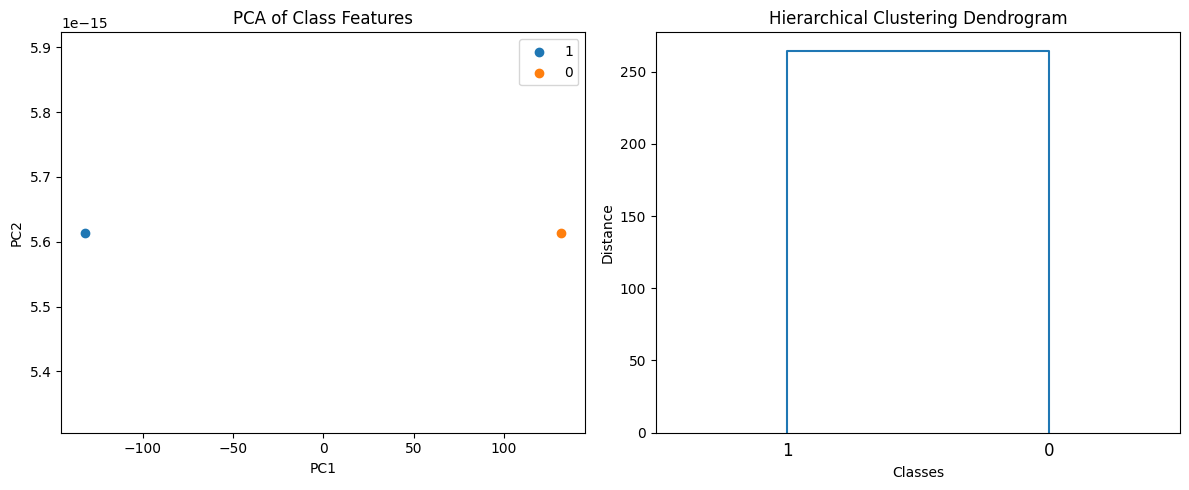

Plot saved to ./dataset_exploration/plot_length_distribution_by_class


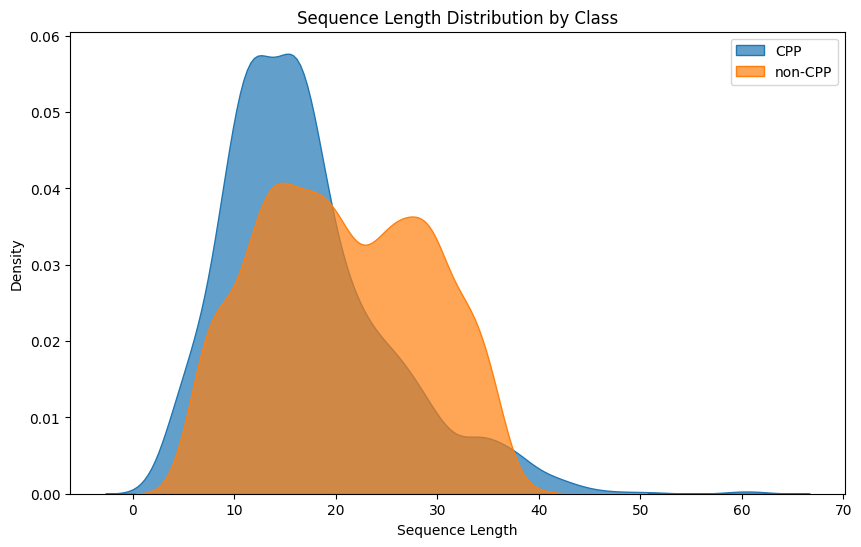

Plot saved to ./dataset_exploration/AminoAcidComposition_by_Class


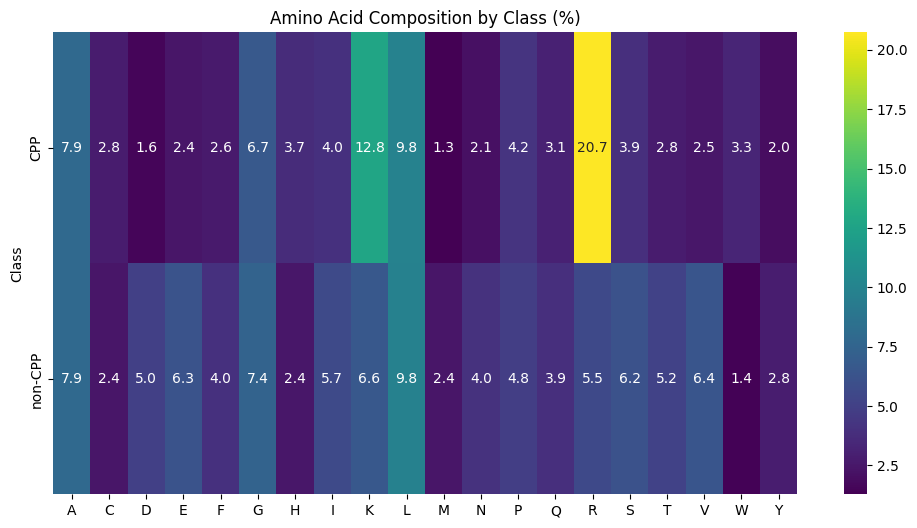

Plot saved to ./dataset_exploration/PhysicochemicalProp_by_class


<Figure size 1200x600 with 0 Axes>

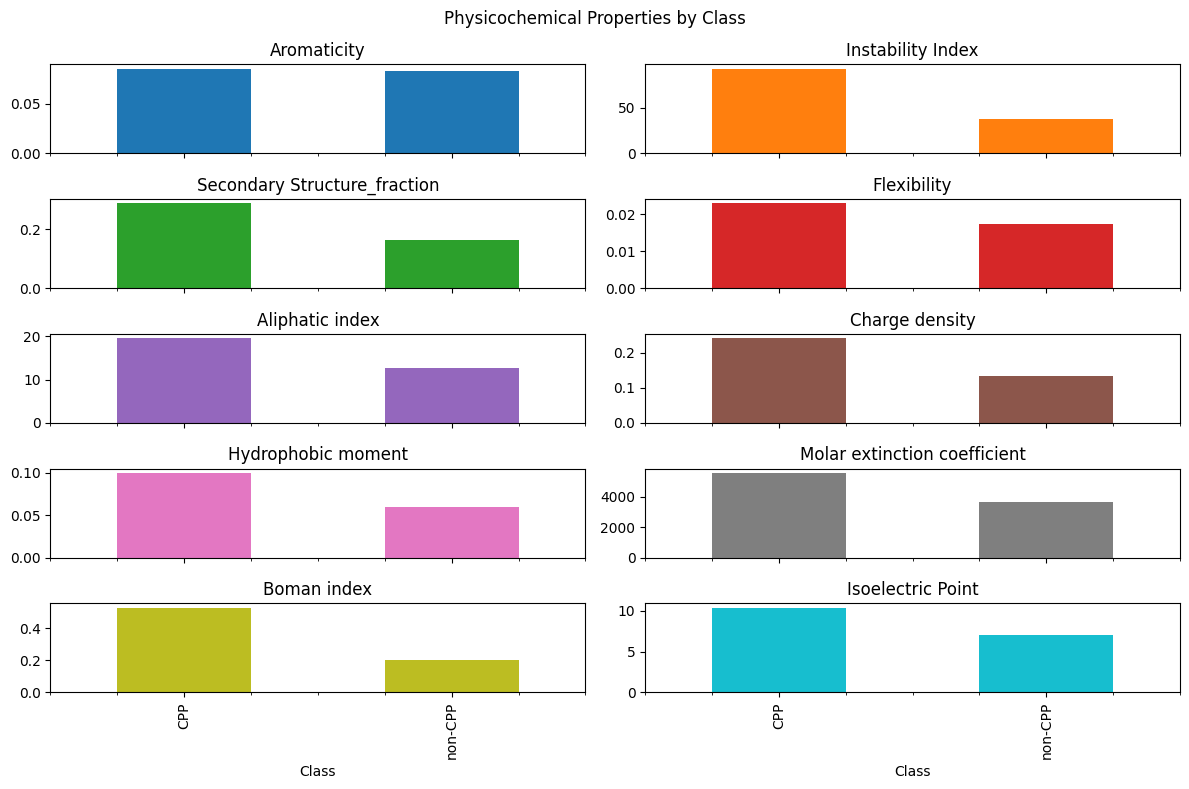

In [44]:
analyzer = SequenceAnalyzer(dataset_path='./Final_non_redundant_sequences.xlsx', label_col='label', sequence_col='sequence')
analyzer.analyze_classes()

Dataset loaded with 192 entries and 2 classes.

Analyzing class: 1 (96 sequences)
  - Avg length: 17.7 ± 4.5
  - Top 3 AAs: [('R', 18.48145968216598), ('L', 13.125367863449089), ('K', 7.710417892878163)]
  - Avg molecular weight: 2196.1
  - Avg isoelectric point: 10.27
  - Avg pairwise similarity: 0.17

Analyzing class: 0 (96 sequences)
  - Avg length: 30.6 ± 11.0
  - Top 3 AAs: [('L', 9.137401977497444), ('A', 8.55779065802932), ('G', 7.807705421070576)]
  - Avg molecular weight: 3392.7
  - Avg isoelectric point: 7.00
  - Avg pairwise similarity: 0.16

Performing clustering analysis...


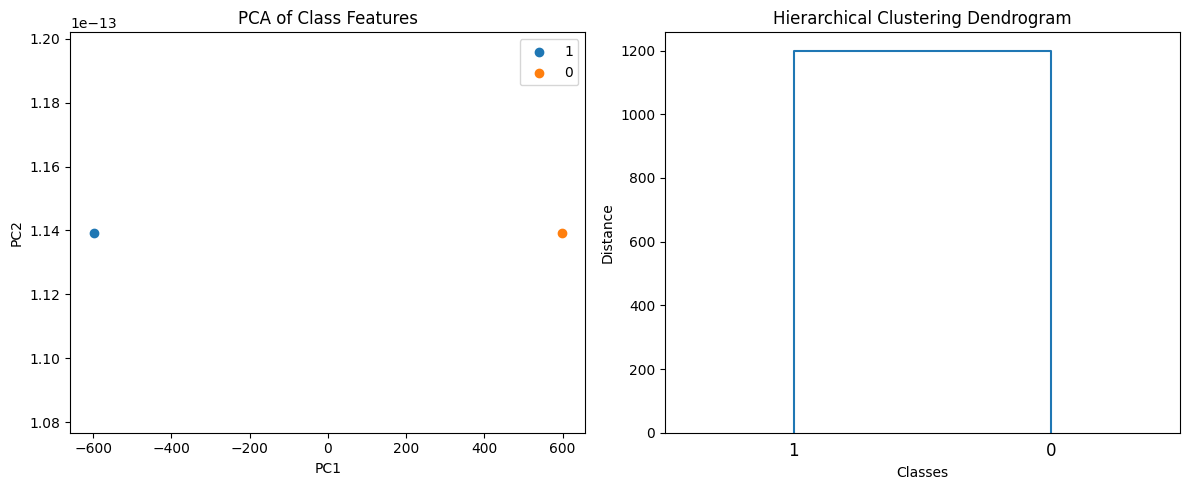

Plot saved to ./dataset_exploration/plot_length_distribution_by_class


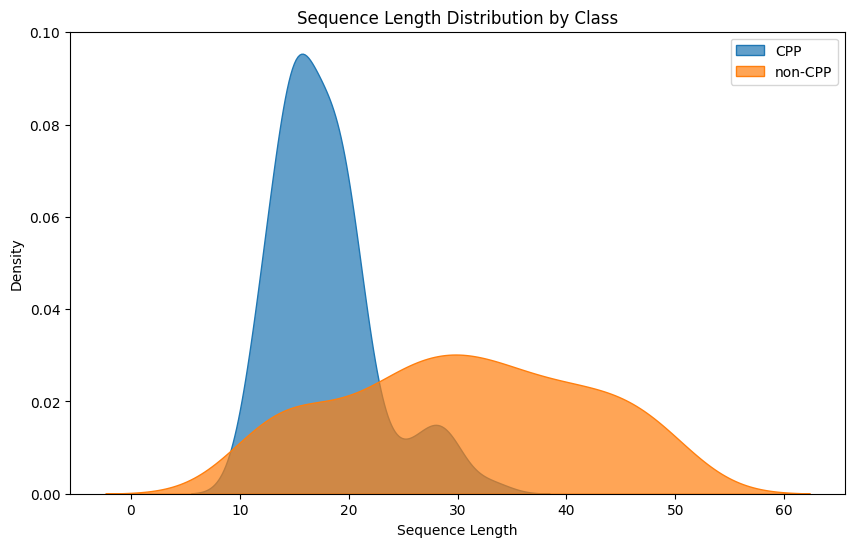

Plot saved to ./dataset_exploration/AminoAcidComposition_by_Class


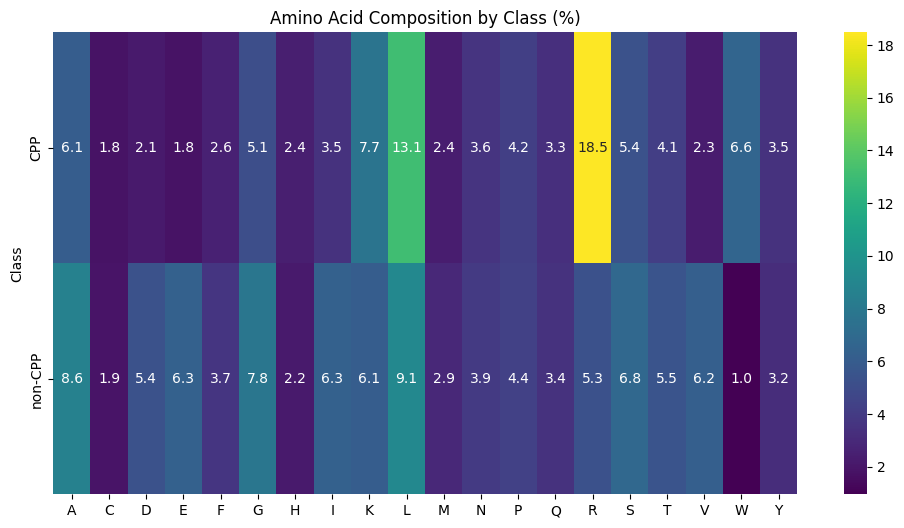

Plot saved to ./dataset_exploration/PhysicochemicalProp_by_class


<Figure size 1200x600 with 0 Axes>

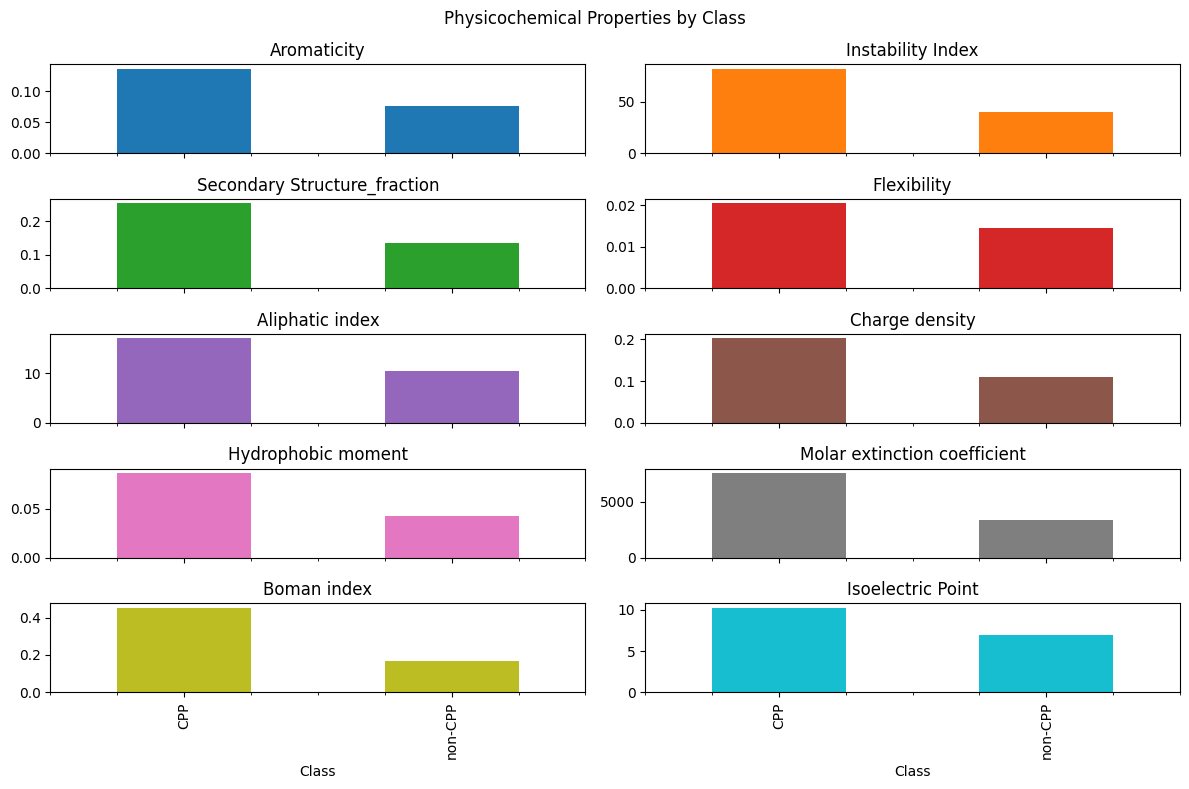

In [45]:
analyzer = SequenceAnalyzer(dataset_path='./kelm.xlsx', label_col='label', sequence_col='sequence')
analyzer.analyze_classes()

/home/castilmg/miniconda3/envs/esm-axp-gdl-env/lib/python3.7/site-packages/umap/umap_.py:1953: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism."


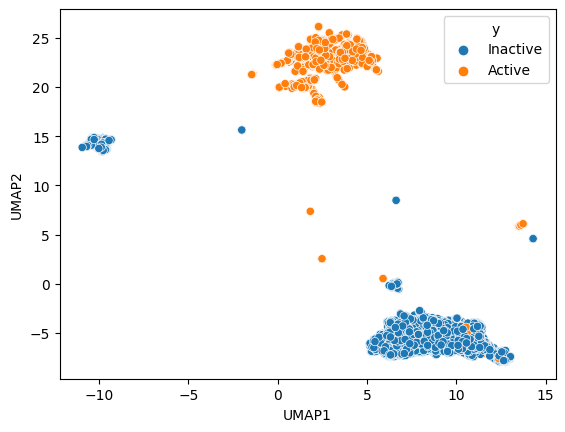

In [15]:
import numpy as np
from umap.umap_ import UMAP
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Load the dataset
dataset = pd.read_excel('Final_non_redundant_sequences.xlsx', na_filter=False)
X_data_name = 'whole_sample_dataset_esm2_t33_650M_UR50D_unified_1280_dimension.csv'
X_data = pd.read_csv(X_data_name, header=0, index_col=0, delimiter=',')
X = np.array(X_data)
y = np.array(dataset['label'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# concatenate the dataset
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

reducer = UMAP(random_state=42)
X_umap = reducer.fit_transform(X, y=y)

# Make a DataFrame for plotting
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
y_new_label=[]
for i in y:
    if i == 0:
        y_new_label.append('Inactive')                  
    if i == 1:
        y_new_label.append('Active')
umap_df["y"] = y_new_label

graph = sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue=umap_df["y"], legend='full')
graph_for_output = graph.get_figure()
graph_for_output.savefig('esm2_t33_650M_UR50D_unified_1280_UMAP.png', dpi=300)

In [3]:
# Load the dataset
dataset = pd.read_excel('Final_non_redundant_sequences.xlsx', na_filter=False)
X_data_name = 'whole_sample_dataset_adj_matrix_ESMFold.csv'
X_data = pd.read_csv(X_data_name, header=0, index_col=0, delimiter=',')
X = np.array(X_data)
y = np.array(dataset['label'])

#print(X_data)